In [10]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

LeNET-5와 동일함

In [11]:
class ImageTransform():    
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [12]:
cat_directory = './data/cd/Cat/'
dog_directory = './data/cd/Dog/'

cat_img_path = sorted([os.path.join(cat_directory,f) for f in os.listdir(cat_directory)])
dog_img_path = sorted([os.path.join(dog_directory,f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_img_path,*dog_img_path]
correct_imges_file_paths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_imges_file_paths)
train_images_filepaths = correct_imges_file_paths[:400]
val_images_filepaths = correct_imges_file_paths[400:-10]
test_images_filepaths = correct_imges_file_paths[-10:]
print(len(train_images_filepaths),len(val_images_filepaths),len(test_images_filepaths))

400 92 10


In [13]:
class DogvCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase ='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [14]:
size = 256
mean = (0.485,0.456,0.406)
std = (0.229,0.224,0.225)
batch_size = 32

In [15]:
train_dataset = DogvCatDataset(train_images_filepaths,transform = ImageTransform(size,mean,std), phase = 'train')
val_dataset = DogvCatDataset(val_images_filepaths,transform = ImageTransform(size,mean,std), phase='val')
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train':train_dataloader, 'val':val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1])


AlexNet Architecture

In [17]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,11,4,2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2),
            nn.Conv2d(64,192,5,1,2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2),
            nn.Conv2d(192,384,3,1,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256,3,1,1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,256,3,1,1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096,512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512,2)
        )
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1) # 첫번쨰는 batch_size이니까~
        x = self.classifier(x)
        return x

In [18]:
model = AlexNet()
model = model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
from torchsummary import summary
model.to(device)
summary(model,input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [20]:
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [21]:
import time

In [27]:
inputs, label = next(batch_iterator)
inputs = inputs.to(device)
label = label.to(device)
output = model(inputs)

Train 역시 LeNet과 동일

In [22]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1,num_epoch))
        print('-'*10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs,1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds ==labels.data)
            
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4}f Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
    time_eplased = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_eplased//60, time_eplased%60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    return model

In [23]:
num_epoch=10
model = train_model(model, dataloader_dict,criterion,optimizer,num_epoch)

Epoch 1/10
----------


/tmp/ipykernel_14555/2338421367.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6936f Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6941f Acc: 0.4891
Epoch 2/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933f Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6938f Acc: 0.4891
Epoch 3/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934f Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6936f Acc: 0.4891
Epoch 4/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932f Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933f Acc: 0.4891
Epoch 5/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927f Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931f Acc: 0.4891
Epoch 6/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.693f Acc: 0.4975


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.693f Acc: 0.4891
Epoch 7/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6926f Acc: 0.5425


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928f Acc: 0.5109
Epoch 8/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6926f Acc: 0.5400


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6926f Acc: 0.5761
Epoch 9/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6925f Acc: 0.5400


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6926f Acc: 0.5870
Epoch 10/10
----------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929f Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6925f Acc: 0.5870
Training complete in 0m 22s
Best val Acc: 0.5870


In [24]:
import pandas as pd
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size,mean,std)
        img = transform(img,phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img) # torch.Size([1, 2]) # case 한개 output 2개
        preds = F.softmax(outputs,dim=1)[:,1].tolist() # 1번째 index를 가져온다 개의 여부
        id_list.append(_id)
        pred_list.append(preds[0])
res = pd.DataFrame({
    'id':id_list,
    'label': pred_list
})
res.sort_values(by='id', inplace=True)
res.reset_index(drop=True, inplace=True)

res.to_csv('./AlexNet.csv',index=False)

/tmp/ipykernel_14555/2417495055.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]

In [25]:
class_ = classes = {0:'cat',1:'dog'}
def display_image_grid(images_filepaths,predicted_labels=(),cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows,ncols=cols,figsize=(12,6))
    for i, images_filepath in enumerate(images_filepaths):
        image = cv2.imread(images_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        label = res.loc[res['id']==a, 'label'].values[0]
        if label > 0.5:
            label=1
        else:
            label=0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

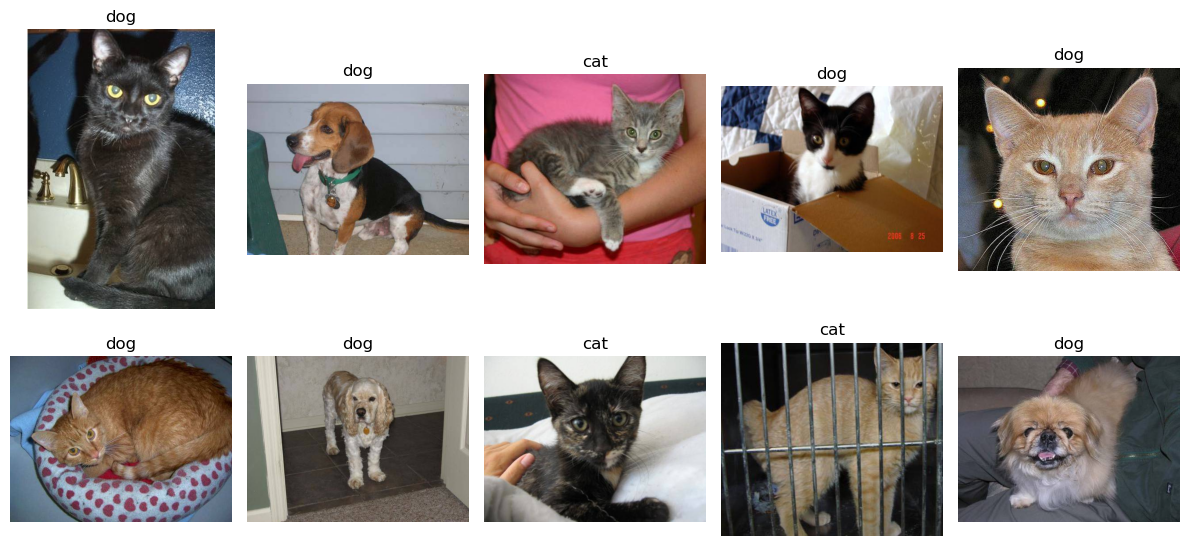

In [26]:
display_image_grid(test_images_filepaths)